In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

In [12]:
# Load Data
def load_price_data(tickers, start_date, end_date):
  data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
  price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
  return data[price_col]

In [13]:
# Compute Statistics and Returns
def compute_statistics(price_df):
  daily_returns = price_df.pct_change().dropna()
  mu = daily_returns.mean() * 252
  cov = daily_returns.cov() * 252
  return mu, cov

In [14]:
# Single Period Mean Variance Optimisation
def optimise_port(mu, cov, target_return=None):
  n = len(mu)
  w = cp.Variable(n)
  portfolio_var = cp.quad_form(w, cov)
  constraints = [cp.sum(w) == 1, w >= 0]
  if target_return is not None:
      constraints.append(mu.values.T @ w >= target_return)

  prob = cp.Problem(cp.Minimize(portfolio_var), constraints)
  prob.solve()
  return pd.Series(w.value, index=mu.index)

In [15]:
# Efficient Frontier
def efficient_frontier(mu, cov, returns_range, points=50):
  frontier = []
  for r in np.linspace(returns_range[0], returns_range[1], points):
      w = optimise_port(mu, cov, target_return=r)
      port_ret = float(mu.values @ w.values)
      port_risk = float(np.sqrt(w.values.T @ cov.values @ w.values))
      frontier.append({'Target': r, 'Return': port_ret, 'Risk': port_risk, 'Weights': w})
  return pd.DataFrame(frontier)

In [16]:
def plot_frontier(frontier_df):
    plt.figure(figsize=(8,6))
    plt.plot(frontier_df['Risk'], frontier_df['Return'], marker='o')
    plt.xlabel('Risk (Std Dev)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.grid(True)
    plt.show()

[*********************100%***********************]  4 of 4 completed


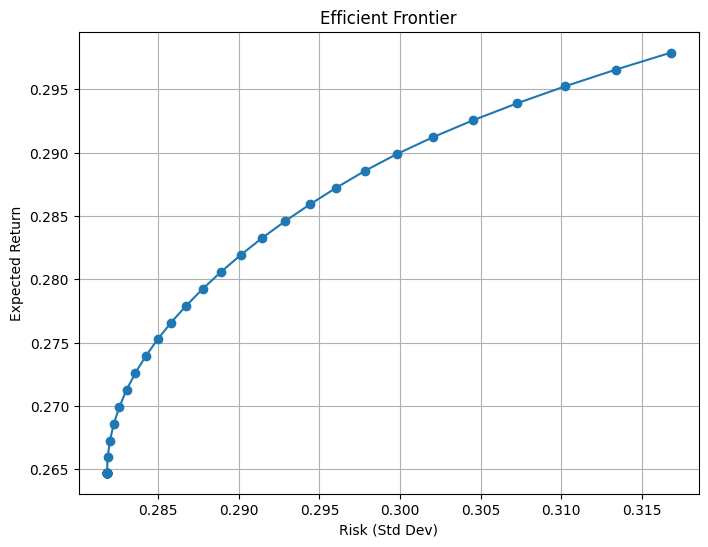

Optimised Weights for Return = 15.00%:
Ticker
AAPL     0.322542
AMZN     0.126638
GOOGL    0.238775
MSFT     0.312046
dtype: float64


In [18]:
if __name__ == '__main__':
    # User inputs
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
    start_date = '2020-01-01'
    end_date   = '2025-01-01'

    # 1. Load data
    prices = load_price_data(tickers, start_date, end_date)

    # 2. Compute statistics
    mu, cov = compute_statistics(prices)

    # 3. Compute efficient frontier
    ret_min, ret_max = mu.min(), mu.max()
    frontier = efficient_frontier(mu, cov, (ret_min, ret_max), points=50)

    # 4. Plot
    plot_frontier(frontier)

    # 5. Example: optimise for a specific return
    target_return = 0.15
    weights = optimise_port(mu, cov, target_return=target_return)
    print(f"Optimised Weights for Return = {target_return*100:.2f}%:")
    print(weights)